# Prophet

ProphetはMetaが開発した時系列予測アルゴリズム。

大量のビジネス時系列を **スケールして扱うための実務的予測モデル** を提案したもの。目的は次の通り

- 多数の異なる時系列（製品・地域・チャネルなど）を一括処理したい  
- モデル構築者が必ずしも時系列の専門家ではない  
- トレンド変化・季節性・祝日効果などを柔軟に扱いたい  

RとPythonのパッケージも公開されている。

:::{card}

- Webサイト：[Prophet | Forecasting at scale.](https://facebook.github.io/prophet/)
- 論文：[Taylor SJ, Letham B. 2017. Forecasting at scale](https://doi.org/10.7287/peerj.preprints.3190v2)

:::

::{note}

パッケージとしては sktime にラッパーがあるのでそちらを入れたほうが使いやすいかも  
[Prophet — sktime documentation](https://www.sktime.net/en/v0.39.0/api_reference/auto_generated/sktime.forecasting.fbprophet.Prophet.html)

:::

## モデルの構造

時系列をトレンド、季節性、イベント効果、ノイズに分解するモデル構造をとっている。


時系列データ $y(t)$ を次のような構造で表す：

:::{admonition} decomposable time series model (Harvey & Peters 1990) 

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

ここで：

- $g(t)$：長期トレンド（例：区分線形またはロジスティック成長）  
- $s(t)$：季節成分（年次・週次など）  
- $h(t)$：祝日・イベント効果  
- $\varepsilon_t$：ノイズ（残差項）

:::

### トレンドモデル

トレンド $g(t)$ は 2つのタイプが想定される。

#### 1. 区分線形トレンド

$$
g(t) = (k + a(t)^\top \delta)t + (m + a(t)^\top \gamma)
$$

- $k$：傾き  
- $m$：切片  
- $a(t)$：構造変化点（changepoint）の指示ベクトル  
- $\delta, \gamma$：変化点ごとの補正量  

#### 2. ロジスティック成長トレンド

$$
g(t) = \frac{C}{1 + \exp(-k(t - m))}
$$

- $C$：キャパシティ（上限）  
- $k$：成長率  
- $m$：シグモイド中心  

このようにして、製品売上など「最初は急成長し、後に飽和する」ようなデータも表現できる。

### 季節成分（Fourier 展開）

$$
s(t) = \sum_{n=1}^{N} \left( a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right)
$$

- $P$：周期（例：7 日、365 日）  
- $a_n, b_n$：Fourier 係数  
- $N$：項の数（モデルの柔軟性を制御）  

### 祝日・イベント成分

$$
h(t) = \sum_{i=1}^{L} \kappa_i D_i(t)
$$

- $D_i(t)$：イベント $i$ に対応するダミー変数  
- $\kappa_i$：そのイベントの効果量（推定パラメータ）

### 残差項

$$
\varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

Prophet では正規分布を仮定するが、ロバスト化（Laplace 分布など）も可能


## モデルの特徴

- **アナリスト・イン・ザ・ループ設計**  
  - 変化点の手動指定が可能  
  - キャパシティ $C$ の設定で「成長上限」を反映  
  - 国や地域ごとの祝日カレンダーを調整可能  
  - トレンド・季節性の柔軟性をハイパーパラメータで制御可能  
- **評価・監視フレームワーク**  
  - ベースラインとの比較（例：単純平均、季節なしモデル）  
  - 過去データを用いた “Simulated Historical Forecasts (SHF)” により誤差分布を推定  
  - 誤差が大きい系列を自動検出し、アナリストにレビューを促す  



## 限界・注意点

- ARIMA や状態空間モデルのような自己相関構造は明示的に扱わない  
- 変化点やハイパーパラメータの調整には一定の経験が必要  
- 「完全自動」よりも「人の介入を前提」とした設計  


## 実装

[Prophet — sktime documentation](https://www.sktime.net/en/v0.39.0/api_reference/auto_generated/sktime.forecasting.fbprophet.Prophet.html)

- `sktime` パッケージと `prophet` パッケージをインストールすれば、sktimeのインターフェイスで統一的に扱える

21:34:00 - cmdstanpy - INFO - Chain [1] start processing
21:34:00 - cmdstanpy - INFO - Chain [1] done processing
/home/mitama/notes/.venv/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:860: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/home/mitama/notes/.venv/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:874: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)


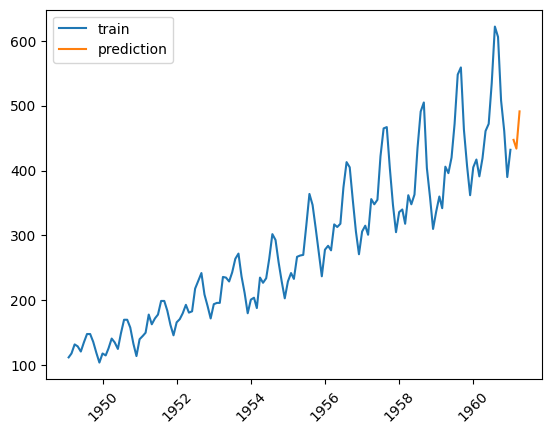

In [12]:
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet
# Prophet requires to have data with a pandas.DatetimeIndex
y = load_airline().to_timestamp(freq='M')
forecaster = Prophet(
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh=[1,2,3])

import matplotlib.pyplot as plt
plt.plot(y, label="train")
plt.plot(y_pred, label="prediction")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## 参考

- [[R] fb Prophet の解剖で学ぶベイズ時系列モデリング - ill-identified diary](https://ill-identified.hatenablog.com/entry/2018/05/28/020224)